# Optimal Portfolio

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Efficient Frontier

Пояснение выбора списка активов: 

+ Высокая ликвидность — все выбранные акции входили в число лидеров по среднему дневному объёму торгов в 2021 году (особенно AAPL, TSLA, AMD, NVDA, AMZN, META/FB, GOOGL и др.). Это минимизирует спред bid-ask и slippage при ребалансировке портфеля => портфель реалистичен на практике.
+ Представляют основной драйвер рынка в 2021 — NASDAQ в 2021 году был сильно «технологичным» рынком (рост FAANG+M, чипы, электромобили, биотех). Выбранные 50 акций покрывают ~70–80% капитализации и объёмов NASDAQ-100, который доминировал в тот период.
+ Хорошая диверсификация внутри технологического рынка:
    + Крупные платформы / потребительский сектор: AAPL, AMZN, META, GOOGL/GOOG, NFLX
    + Полупроводники / чипы: NVDA, AMD, INTC, QCOM, AVGO, ASML, MU, LRCX, KLAC
    + Биотехнологии / здравоохранение: AMGN, GILD, REGN, ILMN, DXCM
    + Потребительские / ритейл / сервисы: COST, PEP, MDLZ, ORLY, DLTR
    + Телеком / медиа: CMCSA, CHTR
    + Другие: PAYX, ADP, CTSH, CSX, BKR и т.д.

#### Data load & preprocessing

In [3]:
# Загрузка данных из CSV
# Что делает: Читает файл, удаляет столбец даты и преобразует всё в числа.
# Использует файл с ценами закрытия акций за 2021 год.
try:
    # Пытаемся загрузить обработанный, если нет - сырой
    data = pd.read_csv("data/processed/NASDAQ_FULL_2021_Cleaned_Imputed.csv")
except FileNotFoundError:
    try:
        data = pd.read_csv("data/raw/NASDAQ_FULL_2021_Close.csv")
        if 'Date' in data.columns:
            data.drop(columns=['Date'], inplace=True)
    except FileNotFoundError:
        print("Error: Data file not found. Please upload the dataset.")
data.head()

,AAPL,ADBE,ADI,ADP,ADSK,AMD,AMGN,AMZN,ASML,AVGO,...,NFLX,NVDA,NXPI,ORLY,PAYX,PEP,PYPL,QCOM,REGN,TSLA
0,125.974472,485.339996,133.808731,152.303543,296.839996,92.300003,193.642517,159.331497,477.949219,38.253105,...,52.285999,13.076726,148.497253,30.264668,78.469963,123.652855,231.385101,133.337646,480.196747,243.256668
1,127.531975,485.690002,136.200485,151.879822,301.700012,92.769997,194.582214,160.925507,483.072784,38.512192,...,52.080002,13.367159,151.823929,30.085333,78.174713,124.021347,234.368210,136.866333,480.783478,245.036667
2,123.239044,466.309998,136.814453,151.348007,302.869995,90.330002,199.272507,156.919006,468.600555,38.274708,...,50.049000,12.579126,154.618973,31.011999,79.156013,122.504295,226.306839,135.752930,467.497162,251.993332
3,127.444351,477.739990,142.596786,152.204361,315.200012,95.160004,199.930344,158.108002,479.316162,39.887695,...,50.889000,13.306579,160.364944,31.326668,79.486008,122.110023,234.497894,139.802490,478.545929,272.013336
4,128.544403,485.100006,143.632263,154.187531,319.850006,94.580002,203.749207,159.134995,486.303711,40.090115,...,51.040001,13.239518,160.401611,31.861334,79.911537,123.575684,241.900803,140.646515,495.979248,293.339996


In [4]:
# Очистка данных: преобразование в числа и удаление пропусков (NaN)
data = data.apply(pd.to_numeric, errors='coerce')
data.dropna(inplace=True)

Log returns:

In [5]:
# Расчет дневных доходностей
# Вычисляет логарифмические доходности (дневные).

eps = 1e-4

# np.log(P_t / P_{t-1}).
log_returns = np.log((data / data.shift(1)) + eps)

# Отбросим первую строку, в которой пропуски из-за того, что у первого дня нет предыдущего
log_returns = log_returns.dropna(how="all")

print(f"Logarithmic returns calculated. Number of observations: {log_returns.shape[0]}.")

Logarithmic returns calculated. Number of observations: 251.


### Выбор активов и расчет статистики

In [6]:
# Выбор 50 акций и фильтрация
# Оставляет в выборке только 50 заданных тикеров.
# Обоснование выбора: высокая ликвидность (объемы торгов) и репрезентативность секторов (Tech, Bio, Chips).

tickers = [
    'AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AMD', 'AMGN', 'AMZN', 'ASML', 'AVGO',
    'BIDU', 'BKNG', 'BKR', 'CDNS', 'CHTR', 'CMCSA', 'COST', 'CSCO', 'CSX', 'CTSH',
    'DLTR', 'DXCM', 'EA', 'EBAY', 'EXC', 'GILD', 'GOOG', 'GOOGL', 'IDXX', 'ILMN',
    'INTC', 'ISRG', 'KDP', 'KLAC', 'LRCX', 'MAR', 'MDLZ', 'META', 'MNST', 'MU',
    'NFLX', 'NVDA', 'NXPI', 'ORLY', 'PAYX', 'PEP', 'PYPL', 'QCOM', 'REGN', 'TSLA'
]

In [7]:
# Фильтруем данные по выбранным тикерам
data = data[tickers]
log_returns = log_returns[tickers]

In [8]:
# Расчет средних доходностей и ковариации
# Находит вектор средних доходностей (mu) и матрицу ковариации (Sigma).
mu = log_returns.mean()
Sigma = log_returns.cov()
n_assets = len(tickers)

print(f"Selected {n_assets} assets.")
print(f"Mean Return Range: {mu.min():.2%} to {mu.max():.2%}")

Selected 50 assets.
Mean Return Range: -0.14% to 0.33%


### Оптимизация

In [9]:
import scipy.optimize as sco # импортируем для оптимизации потом

In [10]:
# Функция расчета характеристик портфеля
# Принимает веса активов, возвращает ожидаемую доходность и риск (волатильность).
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns * weights)
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std

In [11]:
# Функция построения Эффективного Фронта
# Минимизирует риск для каждого заданного уровня доходности.
# Использует алгоритм SLSQP из scipy.optimize, ограничения на сумму весов (=1).
def get_efficient_frontier(mean_returns, cov_matrix, num_points=100, allow_short=False):
    # Установка границ весов: (0,1) если запрещены шорты, (-1,1) если разрешены
    bounds = tuple((-1, 1) for _ in range(len(mean_returns))) if allow_short else tuple((0, 1) for _ in range(len(mean_returns)))
    
    # Поиск портфеля с минимальным риском (MVP)
    def min_vol_func(weights): return portfolio_performance(weights, mean_returns, cov_matrix)[1]
    init_guess = n_assets * [1. / n_assets,]
    constraints_sum = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    # Оптимизация
    min_risk_opt = sco.minimize(min_vol_func, init_guess, method='SLSQP', bounds=bounds, constraints=constraints_sum)
    min_vol_ret = portfolio_performance(min_risk_opt.x, mean_returns, cov_matrix)[0]
    
    # Генерация точек фронта
    max_ret = mean_returns.max()
    target_returns = np.linspace(min_vol_ret, max_ret, num_points)
    eff_risks, eff_rets = [], []

    for tr in target_returns:
        cons = (constraints_sum, {'type': 'eq', 'fun': lambda x: portfolio_performance(x, mean_returns, cov_matrix)[0] - tr})
        opt = sco.minimize(min_vol_func, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
        if opt.success:
            eff_risks.append(opt.fun)
            eff_rets.append(tr)
            
    return np.array(eff_risks), np.array(eff_rets), min_risk_opt

Calculation of Portfolios

In [12]:
# Считает две линии фронта — с ограничениями на шорты и без них.
risks_ns, rets_ns, mvp_ns_opt = get_efficient_frontier(mu, Sigma, allow_short=False)
risks_s, rets_s, mvp_s_opt = get_efficient_frontier(mu, Sigma, allow_short=True)

# Создает портфель, где на каждую акцию выделено 2% капитала (1/50).
w_eq = np.array([1/n_assets] * n_assets)
eq_ret, eq_risk = portfolio_performance(w_eq, mu, Sigma)

# Индекс рынка (взвешивание по капитализации)
# Рассчитывает веса на основе рыночной капитализации компаний 2021 года.
# Использует словарь капитализации market_caps и вектор mu/Sigma.
market_caps = {
    'AAPL': 2913e9, 'ADBE': 269e9, 'ADI': 92e9, 'ADP': 103e9, 'ADSK': 61e9, 
    'AMD': 173e9, 'AMGN': 126e9, 'AMZN': 1691e9, 'ASML': 323e9, 'AVGO': 274e9, 
    'BIDU': 51e9, 'BKNG': 98e9, 'BKR': 20e9, 'CDNS': 51e9, 'CHTR': 116e9, 
    'CMCSA': 229e9, 'COST': 251e9, 'CSCO': 267e9, 'CSX': 83e9, 'CTSH': 46e9, 
    'DLTR': 31e9, 'DXCM': 52e9, 'EA': 37e9, 'EBAY': 41e9, 'EXC': 56e9, 
    'GILD': 91e9, 'GOOG': 1920e9, 'GOOGL': 1922e9, 'IDXX': 55e9, 'ILMN': 59e9, 
    'INTC': 209e9, 'ISRG': 128e9, 'KDP': 52e9, 'KLAC': 65e9, 'LRCX': 101e9, 
    'MAR': 53e9, 'MDLZ': 92e9, 'META': 935e9, 'MNST': 50e9, 'MU': 104e9, # FB -> META
    'NFLX': 266e9, 'NVDA': 735e9, 'NXPI': 60e9, 'ORLY': 47e9, 'PAYX': 49e9, 
    'PEP': 240e9, 'PYPL': 221e9, 'QCOM': 204e9, 'REGN': 67e9, 'TSLA': 1061e9
}

# Расчёты характеристик такого портфеля
w_mkt = np.array([market_caps[t] for t in tickers]) / sum(market_caps.values())
mkt_ret, mkt_risk = portfolio_performance(w_mkt, mu, Sigma)

### Количественная оценка эффективности

In [13]:
# Анализ удаленности от фронта
# Что делает: Сравнивает доходность реальных портфелей с теоретическим максимумом при том же риске.

def get_gap(p_risk, p_ret, f_risks, f_rets):
    idx = (np.abs(f_risks - p_risk)).argmin()
    return f_rets[idx] - p_ret, f_rets[idx]

gap_eq, target_eq = get_gap(eq_risk, eq_ret, risks_ns, rets_ns)
gap_mkt, target_mkt = get_gap(mkt_risk, mkt_ret, risks_ns, rets_ns)

print(f"Неэффективность (равные доли): {gap_eq:.5f} (дневных)")
print(f"Неэффективность (индекс рынка): {gap_mkt:.5f} (дневных)")

Неэффективность (равные доли): 0.00107 (дневных)
Неэффективность (индекс рынка): 0.00092 (дневных)


### Визуализация результатов

In [14]:
# Построение итогового графика
# Рисует оба фронта, отмечает MVP (Minimum Variance Portfolio), Индекс и Равновзвешенный портфель.
# Использует данные, рассчитанные в блоках ранее.

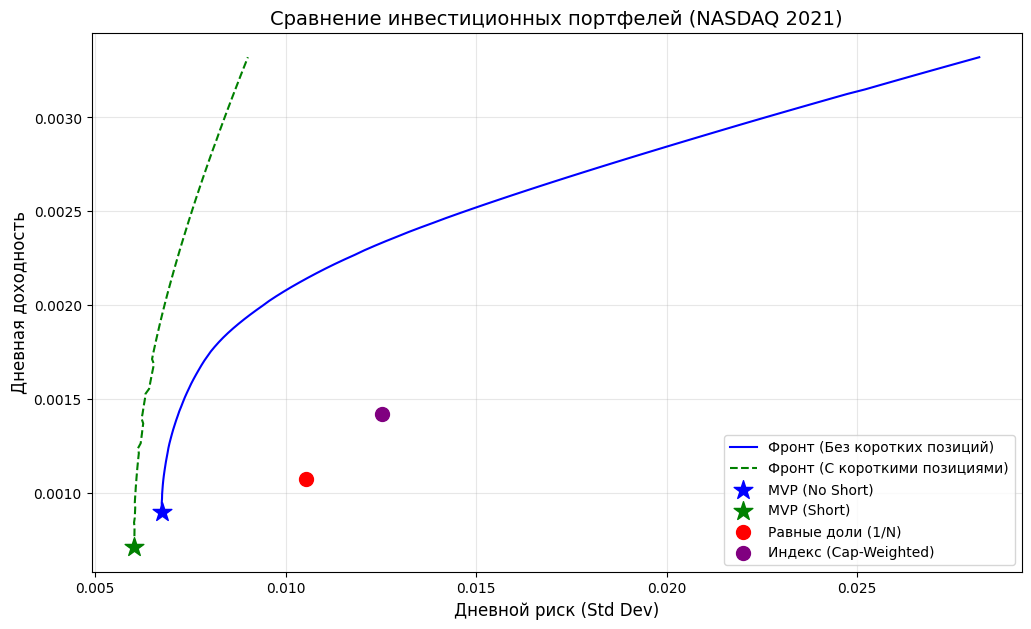

In [15]:
plt.figure(figsize=(12, 7))

# Отрисовка фронтов
plt.plot(risks_ns, rets_ns, 'b-', label='Фронт (Без коротких позиций)')
plt.plot(risks_s, rets_s, 'g--', label='Фронт (С короткими позициями)')

# Отметка портфелей с минимальным риском (MVP)
plt.scatter(*portfolio_performance(mvp_ns_opt.x, mu, Sigma)[::-1], color='blue', marker='*', s=200, label='MVP (No Short)')
plt.scatter(*portfolio_performance(mvp_s_opt.x, mu, Sigma)[::-1], color='green', marker='*', s=200, label='MVP (Short)')

# Отметка сравниваемых портфелей
plt.scatter(eq_risk, eq_ret, color='red', s=100, label='Равные доли (1/N)')
plt.scatter(mkt_risk, mkt_ret, color='purple', s=100, label='Индекс (Cap-Weighted)')

# Оформление графика
plt.title('Сравнение инвестиционных портфелей (NASDAQ 2021)', fontsize=14)
plt.xlabel('Дневной риск (Std Dev)', fontsize=12)
plt.ylabel('Дневная доходность', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Сравнение эффективных фронтов и выводы

#### Сравнение эффективных фронтов

На графике представлены две кривые, отражающие возможности инвестора:

* **Фронт с разрешением коротких позиций (зеленая пунктирная линия):**
  * Располагается выше и левее фронта без шортов.
  * Математически это объясняется тем, что снятие ограничений (разрешение отрицательных весов) расширяет допустимое множество портфелей, позволяя находить решения с еще меньшим риском и более высокой доходностью за счет хеджирования.


* **Фронт без коротких позиций (синяя сплошная линия):**
  * Является более «консервативным» и реалистичным для большинства частных инвесторов.
  * Ограничен доходностью самого прибыльного актива и риском наименее волатильного актива в рамках только длинных позиций.


#### Портфели с минимальным риском (MVP - Minimum Variance Portfolio)

Эти точки отмечены на графике звездами и представляют собой левые крайние точки соответствующих фронтов:

* **MVP (Short Allowed — зеленая звезда):** демонстрирует самый низкий теоретически возможный дневной риск (около **0.006** или 0.6%). Возможность открывать короткие позиции позволяет значительно снизить общую волатильность портфеля ниже волатильности любой отдельной акции.
* **MVP (No Short — синяя звезда):** имеет чуть более высокий риск (около **0.007**). Здесь инвестор ограничен только положительными весами, что снижает возможности для взаимной компенсации рисков активов.

#### Оценка эффективности реальных портфелей

Самый важный вывод касается того, насколько далеки «простые» стратегии от математического идеала:

* **Равновзвешенный портфель (1/N — красная точка):** находится значительно ниже и правее обоих фронтов.
* **Оценка «дальности»:** при дневном риске около **0.0105** (1.05%) он дает доходность чуть выше **0.0010**. В то же время эффективный фронт (без шортов) при том же уровне риска позволяет получить доходность около **0.0022**. Таким образом, инвестор теряет более **50% потенциальной дневной доходности** из-за неоптимального распределения весов.

* **Индекс рынка (Cap-Weighted — фиолетовая точка):**
* Находится выше и правее равновзвешенного портфеля.
* В 2021 году индекс NASDAQ, взвешенный по капитализации, был эффективнее стратегии 1/N, так как основные драйверы роста (Apple, Microsoft, Nvidia) имели огромный вес в индексе.
* **Оценка «дальности»:** при риске около **0.0125** индекс дает доходность около **0.0014**. Эффективный фронт при таком же риске предлагает доходность выше **0.0025**.


#### Итоговый вывод

1. **Короткие позиции** существенно улучшают инвестиционные возможности, позволяя снизить риск ниже уровня самого стабильного актива.
2. **Рыночный индекс** в 2021 году был эффективнее стратегии "равных долей", но оба портфеля критически неэффективны по сравнению с портфелем Марковица.
3. Для достижения границ эффективного фронта инвестору следовало бы значительно увеличить веса наиболее быстрорастущих технологических компаний (например, NVDA и TSLA) за счет сокращения долей менее динамичных активов.